In [1]:
import FinanceDataReader as fdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from pykrx import stock
from pykrx import bond
from finta import TA
from ta import add_all_ta_features
from ta.utils import dropna
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMClassifier, plot_importance

In [44]:
# 카카오 주가

df1 = fdr.DataReader('035720', '2021-01-01', '2022-06-01')
df1

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-01-04,78680,79583,77375,79483,853740,0.016680
2021-01-05,78880,79381,77676,78881,748559,-0.007574
2021-01-06,79282,82291,79181,79383,1435715,0.006364
2021-01-07,80687,80987,78880,80788,775191,0.017699
2021-01-08,82896,87512,81189,87111,2466715,0.078267
...,...,...,...,...,...,...
2022-05-25,81000,82000,80300,81800,1365261,0.014888
2022-05-26,81900,83300,81000,81500,1338305,-0.003667
2022-05-27,82400,83000,81500,81700,1038755,0.002454


<AxesSubplot:xlabel='Date'>

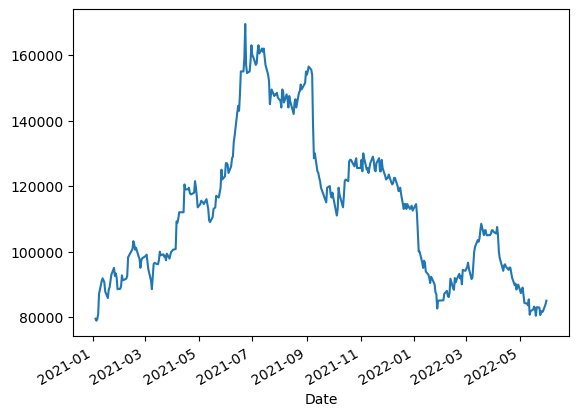

In [45]:
df1['Close'].plot()

<AxesSubplot:xlabel='Date'>

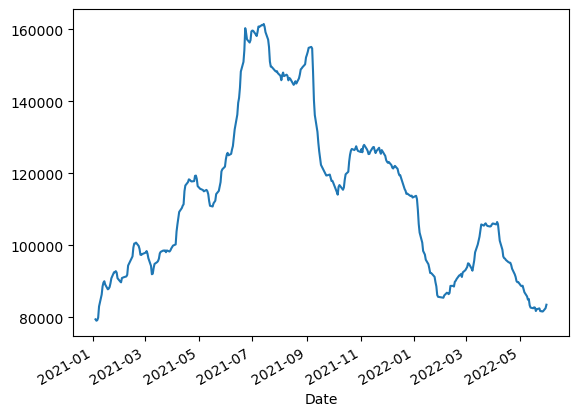

In [46]:
# 지수평활

# 위의 데이터는 대략적이며 시계열에 대한 스파이크가 많이 포함되어 있음을 알 수 있습니다. 매우 부드럽지 않으며 모델이 추세를 추출하기 어려울 수 있습니다. 이를 줄이기 위해 기술 지표를 계산하기 전에 데이터를 기하급수적으로 평활화하려고 합니다.
# 고점과 저점이 많으면 근사하기 어렵거나 기술적 지표를 계산할 때 추세를 추출하기 어려울 수 있습니다. 그것은 모델을 버릴 수 있습니다.

def _exponential_smooth(data, alpha):

    return data.ewm(alpha=alpha).mean()

df1['Close'] = _exponential_smooth(df1['Close'], 0.4)


df1['Close'].plot()

In [47]:
df1 = df1.rename(columns = {'Volume' : 'volume'})

In [48]:
df1

,Open,High,Low,Close,volume,Change
Date,,,,,,
2021-01-04,78680,79583,77375,79483.000000,853740,0.016680
2021-01-05,78880,79381,77676,79106.750000,748559,-0.007574
2021-01-06,79282,82291,79181,79247.693878,1435715,0.006364
2021-01-07,80687,80987,78880,79955.555147,775191,0.017699
2021-01-08,82896,87512,81189,83059.061763,2466715,0.078267
...,...,...,...,...,...,...
2022-05-25,81000,82000,80300,81773.805238,1365261,0.014888
2022-05-26,81900,83300,81000,81664.283143,1338305,-0.003667
2022-05-27,82400,83000,81500,81678.569886,1038755,0.002454


In [49]:
# 나스닥 지수

df2 = fdr.DataReader('IXIC', '2021-01-01', '2022-06-01')
df2

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,12958.519531,12958.719727,12543.240234,12698.450195,12698.450195,6636170000
2021-01-05,12665.650391,12828.269531,12665.650391,12818.959961,12818.959961,6971860000
2021-01-06,12666.150391,12909.629883,12649.990234,12740.790039,12740.790039,7689880000
2021-01-07,12867.339844,13090.910156,12867.339844,13067.480469,13067.480469,6841480000
2021-01-08,13160.219727,13208.089844,13036.549805,13201.980469,13201.980469,7289390000
...,...,...,...,...,...,...
2022-05-24,11326.440430,11351.610352,11092.480469,11264.450195,11264.450195,4724430000
2022-05-25,11225.030273,11511.900391,11211.849609,11434.740234,11434.740234,4519690000
2022-05-26,11409.839844,11796.969727,11406.160156,11740.650391,11740.650391,4672620000


In [50]:
df2['Change'] = (df2['Close'] - df2['Close'].shift(1))/df2['Close'].shift(1)

df2

,Open,High,Low,Close,Adj Close,Volume,Change
Date,,,,,,,
2021-01-04,12958.519531,12958.719727,12543.240234,12698.450195,12698.450195,6636170000,NaN
2021-01-05,12665.650391,12828.269531,12665.650391,12818.959961,12818.959961,6971860000,0.009490
2021-01-06,12666.150391,12909.629883,12649.990234,12740.790039,12740.790039,7689880000,-0.006098
2021-01-07,12867.339844,13090.910156,12867.339844,13067.480469,13067.480469,6841480000,0.025641
2021-01-08,13160.219727,13208.089844,13036.549805,13201.980469,13201.980469,7289390000,0.010293
...,...,...,...,...,...,...,...
2022-05-24,11326.440430,11351.610352,11092.480469,11264.450195,11264.450195,4724430000,-0.023478
2022-05-25,11225.030273,11511.900391,11211.849609,11434.740234,11434.740234,4519690000,0.015117
2022-05-26,11409.839844,11796.969727,11406.160156,11740.650391,11740.650391,4672620000,0.026753


In [51]:
df1['RSI'] = TA.RSI(df1, 4)
df1['MACD'] = TA.MACD(df1, 4)['MACD']
df1['STOCH'] = TA.STOCH(df1, 4)
df1['ADL'] = TA.ADL(df1)
df1['ATR'] = TA.ATR(df1, 4)
df1['MFI'] = TA.MFI(df1, 4)
df1['ROC'] = TA.ROC(df1, 4)
df1['OBV'] = TA.OBV(df1)
df1['CCI'] = TA.CCI(df1, 4)

In [52]:
# 지수생성

def _get_indicator(data):

    data['ema50'] = data['Close'] / data['Close'].ewm(50).mean()
    data['ema20'] = data['Close'] / data['Close'].ewm(20).mean()
    data['ema15'] = data['Close'] / data['Close'].ewm(15).mean()
    data['ema5'] = data['Close'] / data['Close'].ewm(5).mean()

    data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()
    del(data['volume'])
    return data


df = _get_indicator(df1)
print(df.columns)

Index(['Open', 'High', 'Low', 'Close', 'Change', 'RSI', 'MACD', 'STOCH', 'ADL',
       'ATR', 'MFI', 'ROC', 'OBV', 'CCI', 'ema50', 'ema20', 'ema15', 'ema5',
       'normVol', 'Nasdaq'],
      dtype='object')


In [ ]:
df['Nasdaq'] = df2['Change']

In [53]:
df.head(10)

,Open,High,Low,Close,Change,RSI,MACD,STOCH,ADL,ATR,MFI,ROC,OBV,CCI,ema50,ema20,ema15,ema5,normVol,Nasdaq
Date,,,,,,,,,,,,,,,,,,,,
2021-01-04,78680,79583,77375,79483.000000,0.016680,NaN,0.000000,NaN,7.764085e+05,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,NaN
2021-01-05,78880,79381,77676,79106.750000,-0.007574,0.000000,-39.795673,NaN,1.284155e+06,NaN,NaN,NaN,-748559.0,-66.666667,0.997651,0.997685,0.997704,0.997843,0.939966,0.009490
2021-01-06,79282,82291,79181,79247.693878,0.006364,33.309720,-25.520092,NaN,-8.998186e+04,NaN,NaN,NaN,687156.0,100.000000,0.999623,0.999651,0.999666,0.999771,1.368264,-0.006098
2021-01-07,80687,80987,78880,79955.555147,0.017699,79.356360,109.017812,52.492985,-7.375315e+04,2326.562500,48.793872,NaN,1462347.0,51.596618,1.006336,1.006261,1.006219,1.005884,0.806600,0.025641
2021-01-08,82896,87512,81189,83059.061763,0.078267,95.900994,787.294115,54.728159,-1.081379e+06,3663.673713,72.715984,4.499153,3929062.0,133.333333,1.035618,1.035001,1.034660,1.032008,1.786684,0.010293
2021-01-11,88515,92929,86106,86358.998926,0.043772,98.081188,1786.103253,53.235098,-4.004946e+06,5679.408273,90.660600,9.167674,7086809.0,116.318902,1.062488,1.060968,1.060131,1.053731,1.729382,-0.012540
2021-01-12,89518,92327,86909,88609.190313,0.009931,98.706635,2709.581401,69.251835,-4.592533e+06,6375.346041,91.008503,11.812958,8664681.0,74.512380,1.075482,1.072964,1.071586,1.061268,0.892164,0.002761
2021-01-13,92026,92729,90221,89673.388633,-0.006556,98.927150,3302.473579,72.269068,-5.751084e+06,6878.548463,100.000000,12.154044,9471083.0,86.646527,1.075673,1.072285,1.070445,1.057023,0.517048,0.004324
2021-01-14,91123,92929,90321,90057.100107,-0.006599,99.008426,3547.000998,57.908546,-6.715482e+06,5803.340091,100.000000,8.425376,10273159.0,73.849661,1.069959,1.065895,1.063704,1.048209,0.571680,-0.001242


In [54]:
def _produce_pred(data, num):
    
    prediction = (data.shift(-num)['Close'] > data['Close'])
    prediction = prediction.iloc[:-num]
    data['Target'] = prediction.astype(int)
    
    return data

df = _produce_pred(df, num = 5)


df.head()

,Open,High,Low,Close,Change,RSI,MACD,STOCH,ADL,ATR,...,ROC,OBV,CCI,ema50,ema20,ema15,ema5,normVol,Nasdaq,Target
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,78680,79583,77375,79483.000000,0.016680,NaN,0.000000,NaN,7.764085e+05,NaN,...,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.0
2021-01-05,78880,79381,77676,79106.750000,-0.007574,0.000000,-39.795673,NaN,1.284155e+06,NaN,...,NaN,-748559.0,-66.666667,0.997651,0.997685,0.997704,0.997843,0.939966,0.009490,1.0
2021-01-06,79282,82291,79181,79247.693878,0.006364,33.309720,-25.520092,NaN,-8.998186e+04,NaN,...,NaN,687156.0,100.000000,0.999623,0.999651,0.999666,0.999771,1.368264,-0.006098,1.0
2021-01-07,80687,80987,78880,79955.555147,0.017699,79.356360,109.017812,52.492985,-7.375315e+04,2326.562500,...,NaN,1462347.0,51.596618,1.006336,1.006261,1.006219,1.005884,0.806600,0.025641,1.0
2021-01-08,82896,87512,81189,83059.061763,0.078267,95.900994,787.294115,54.728159,-1.081379e+06,3663.673713,...,4.499153,3929062.0,133.333333,1.035618,1.035001,1.034660,1.032008,1.786684,0.010293,1.0


In [55]:
# 결측치 제거

df = df.dropna()

df

,Open,High,Low,Close,Change,RSI,MACD,STOCH,ADL,ATR,...,ROC,OBV,CCI,ema50,ema20,ema15,ema5,normVol,Nasdaq,Target
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-08,82896,87512,81189,83059.061763,0.078267,95.900994,787.294115,54.728159,-1.081379e+06,3663.673713,...,4.499153,3929062.0,133.333333,1.035618,1.035001,1.034660,1.032008,1.786684,0.010293,1.0
2021-01-11,88515,92929,86106,86358.998926,0.043772,98.081188,1786.103253,53.235098,-4.004946e+06,5679.408273,...,9.167674,7086809.0,116.318902,1.062488,1.060968,1.060131,1.053731,1.729382,-0.012540,1.0
2021-01-12,89518,92327,86909,88609.190313,0.009931,98.706635,2709.581401,69.251835,-4.592533e+06,6375.346041,...,11.812958,8664681.0,74.512380,1.075482,1.072964,1.071586,1.061268,0.892164,0.002761,0.0
2021-01-13,92026,92729,90221,89673.388633,-0.006556,98.927150,3302.473579,72.269068,-5.751084e+06,6878.548463,...,12.154044,9471083.0,86.646527,1.075673,1.072285,1.070445,1.057023,0.517048,0.004324,0.0
2021-01-14,91123,92929,90321,90057.100107,-0.006599,99.008426,3547.000998,57.908546,-6.715482e+06,5803.340091,...,8.425376,10273159.0,73.849661,1.069959,1.065895,1.063704,1.048209,0.571680,-0.001242,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-18,83700,84000,82500,82729.799866,-0.007212,13.115869,-6224.095819,60.744997,7.151192e+07,2014.274433,...,-0.752543,-67048604.0,62.409361,0.835499,0.901037,0.916905,0.973220,0.725561,-0.047258,0.0
2022-05-19,80500,81000,80000,81797.879920,-0.026634,7.883046,-6155.959802,41.811161,7.545626e+07,1932.449967,...,-1.131791,-68568137.0,-133.333333,0.828917,0.895541,0.911901,0.968348,0.925667,-0.002597,0.0
2022-05-20,80800,83300,80400,82278.727952,0.032338,27.721794,-5778.986810,56.968199,7.591797e+07,2107.449967,...,-0.341358,-67006596.0,-18.304519,0.836519,0.905080,0.922029,0.978273,0.959048,-0.002975,0.0


In [56]:
X = df.drop(columns='Target')
y = df['Target']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

In [57]:
tscv = TimeSeriesSplit(gap = 4, n_splits=5)

In [79]:
## 랜덤포레스트 모델

def _train_random_forest(X_train, y_train, X_test, y_test):

    
    # Create a new random forest classifier
    rf = RandomForestClassifier(random_state = 42)
    
    # Dictionary of all values we want to test for n_estimators
    params_rf = {'max_depth': np.arange(1, 20)}
    
    # Use gridsearch to test all values for n_estimators
    rf_gs = GridSearchCV(rf, params_rf, cv=tscv, scoring="accuracy")
    
    # Fit model to training data
    rf_gs.fit(X_train, y_train)
    
    # Save best model
    rf_best = rf_gs.best_estimator_
    
    # Check best n_estimators value
    print(rf_gs.best_params_)
    train_pred = rf_best.predict(X_train)
    print(metrics.accuracy_score(y_train, train_pred))
    pred = rf_best.predict(X_test)
    print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))
    print(classification_report(y_test, pred))
    print(confusion_matrix(y_test, pred))
    
    return rf_best
    
rf_model = _train_random_forest(X_train, y_train, X_test, y_test)

{'max_depth': 2}
0.7653846153846153
예측 정확도: 0.6818
              precision    recall  f1-score   support

         0.0       0.85      0.57      0.69        40
         1.0       0.56      0.85      0.68        26

    accuracy                           0.68        66
   macro avg       0.71      0.71      0.68        66
weighted avg       0.74      0.68      0.68        66

[[23 17]
 [ 4 22]]


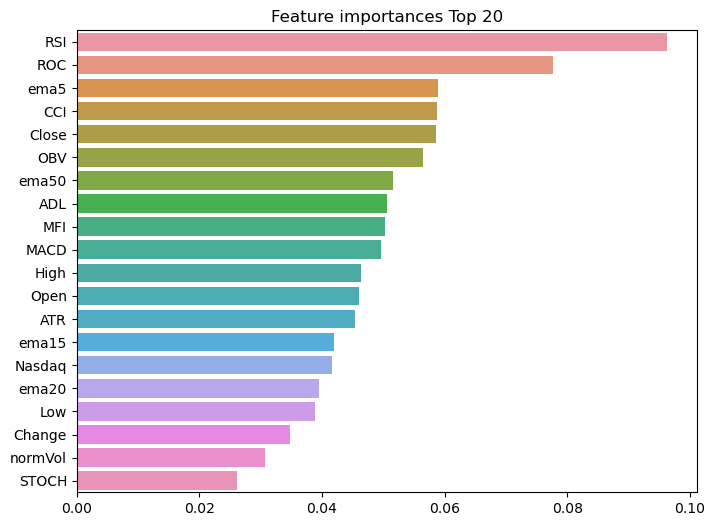

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

rf = RandomForestClassifier(max_depth = 9, random_state = 42)
rf.fit(X_train, y_train)

ftr_importances_values = rf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending = False)[:20]

plt.figure(figsize = (8, 6))
plt.title('Feature importances Top 20')
sns.barplot(x = ftr_top20, y = ftr_top20.index)
plt.show()

In [72]:
## KNN model

def _train_KNN(X_train, y_train, X_test, y_test):

    knn = KNeighborsClassifier()
    # Create a dictionary of all values we want to test for n_neighbors
    params_knn = {'n_neighbors': np.arange(1, 25)}
    
    # Use gridsearch to test all values for n_neighbors
    knn_gs = GridSearchCV(knn, params_knn, cv=tscv, scoring="accuracy")
    
    # Fit model to training data
    knn_gs.fit(X_train, y_train)
    
    # Save best model
    knn_best = knn_gs.best_estimator_
     
    # Check best n_neigbors value
    print(knn_gs.best_params_)
    train_pred = knn_best.predict(X_train)
    print(metrics.accuracy_score(y_train, train_pred))
    pred = knn_best.predict(X_test)
    print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))
    print(classification_report(y_test, pred))
    print(confusion_matrix(y_test, pred))
    
    return knn_best
    
    
knn_model = _train_KNN(X_train, y_train, X_test, y_test)

C:\Users\kh093\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\kh093\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

{'n_neighbors': 18}
0.7423076923076923
예측 정확도: 0.4848
              precision    recall  f1-score   support

         0.0       0.57      0.65      0.60        40
         1.0       0.30      0.23      0.26        26

    accuracy                           0.48        66
   macro avg       0.43      0.44      0.43        66
weighted avg       0.46      0.48      0.47        66

[[26 14]
 [20  6]]


C:\Users\kh093\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\kh093\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

In [73]:
def _train_gbt(X_train, y_train, X_test, y_test):

    gbt = XGBClassifier(random_state = 42)
    params_gbt = {'max_depth': np.arange(1, 25)}
    
    gbt_gs = GridSearchCV(gbt, params_gbt, cv=tscv, scoring="accuracy")
    
    gbt_gs.fit(X_train, y_train)

    gbt_best = gbt_gs.best_estimator_
     
    print(gbt_gs.best_params_)
    train_pred = gbt_best.predict(X_train)
    print(metrics.accuracy_score(y_train, train_pred))
    pred = gbt_best.predict(X_test)
    print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))
    print(classification_report(y_test, pred))
    print(confusion_matrix(y_test, pred))
    return gbt_best
    
    
gbt_model = _train_gbt(X_train, y_train, X_test, y_test)

{'max_depth': 1}
0.9307692307692308
예측 정확도: 0.6515
              precision    recall  f1-score   support

         0.0       0.77      0.60      0.68        40
         1.0       0.54      0.73      0.62        26

    accuracy                           0.65        66
   macro avg       0.66      0.67      0.65        66
weighted avg       0.68      0.65      0.66        66

[[24 16]
 [ 7 19]]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

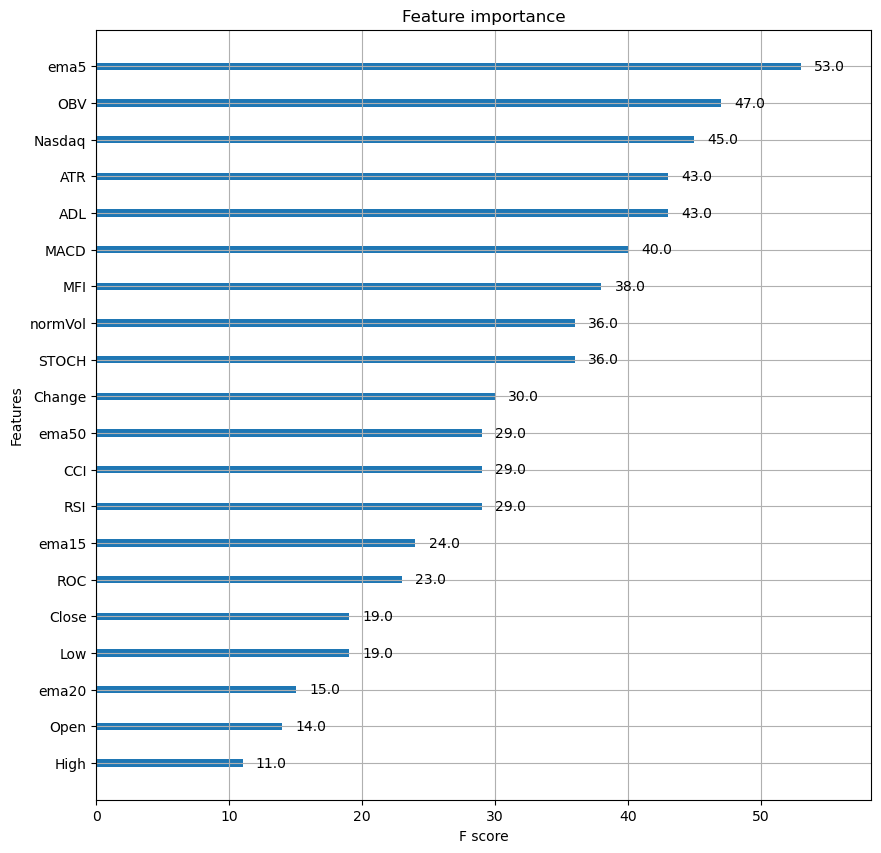

In [80]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

lgb = XGBClassifier(max_depth = 6, random_state = 42)
lgb.fit(X_train, y_train)

%matplotlib inline

fig, ax = plt.subplots(figsize = (10,10))
    
plot_importance(lgb, ax = ax)

In [74]:
# LightGBM 모델

def _train_lgb(X_train, y_train, X_test, y_test):

    lgb = LGBMClassifier(random_state = 42)
    params_lgb = {'max_depth':np.arange(1, 20)}
    lgb_gs = GridSearchCV(lgb, params_lgb, cv=tscv, scoring="accuracy")
    
    lgb_gs.fit(X_train, y_train)

    lgb_best = lgb_gs.best_estimator_
     
    print(lgb_gs.best_params_)
    train_pred = lgb_best.predict(X_train)
    print(metrics.accuracy_score(y_train, train_pred))
    pred = lgb_best.predict(X_test)
    print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))
    print(classification_report(y_test, pred))
    print(confusion_matrix(y_test, pred))
    return lgb_best
    
    
lgb_model = _train_lgb(X_train, y_train, X_test, y_test)

{'max_depth': 1}
0.85
예측 정확도: 0.7576
              precision    recall  f1-score   support

         0.0       0.88      0.70      0.78        40
         1.0       0.65      0.85      0.73        26

    accuracy                           0.76        66
   macro avg       0.76      0.77      0.76        66
weighted avg       0.79      0.76      0.76        66

[[28 12]
 [ 4 22]]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

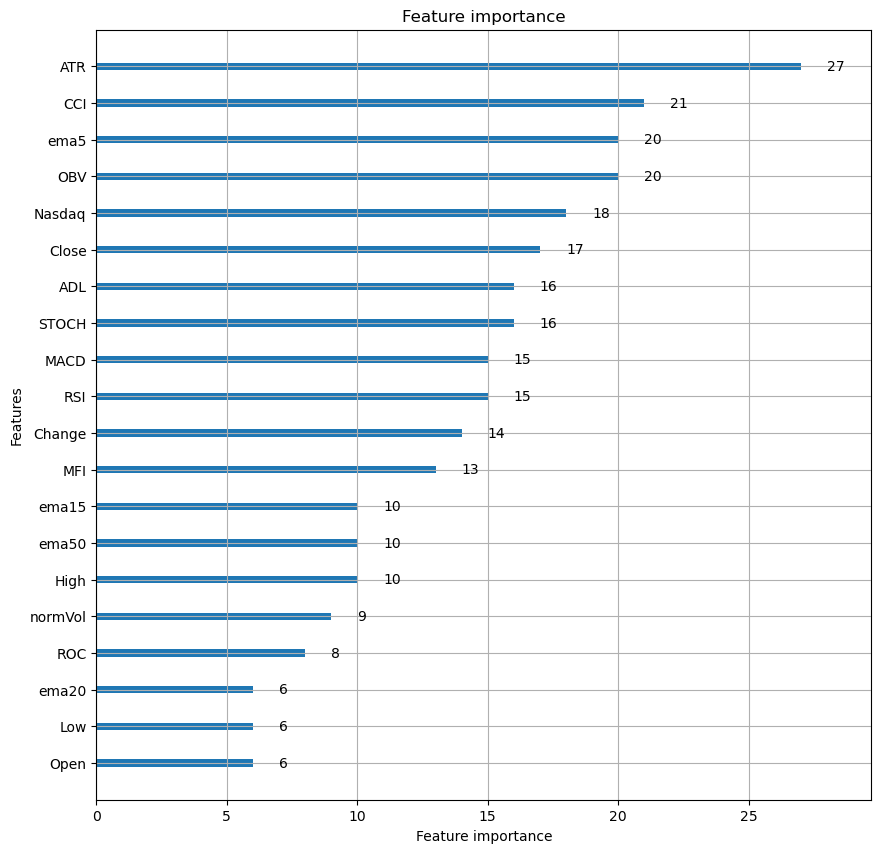

In [83]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt

lgb = LGBMClassifier(learning_rate= 1, max_depth= 2)
lgb.fit(X_train, y_train)

%matplotlib inline

fig, ax = plt.subplots(figsize = (10, 10))
    
plot_importance(lgb, ax = ax)

In [65]:
## 앙상블 보팅 분류기

def _ensemble_model(rf_model, lgb_model, gbt_model, X_train, y_train, X_test, y_test):
    
    estimators=[('lgb', lgb_model), ('rf', rf_model), ('gbt', gbt_model)]
    
    ensemble = VotingClassifier(estimators, voting='hard')
    
    ensemble.fit(X_train, y_train)
    
    print(ensemble.score(X_test, y_test))
    
    pred = ensemble.predict(X_test)
    print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))
    print(classification_report(y_test, pred))
    print(confusion_matrix(y_test, pred))
    
    return ensemble
    
ensemble_model = _ensemble_model(rf_model, knn_model, gbt_model, X_train, y_train, X_test, y_test)

0.6060606060606061
예측 정확도: 0.6061
              precision    recall  f1-score   support

         0.0       0.72      0.57      0.64        40
         1.0       0.50      0.65      0.57        26

    accuracy                           0.61        66
   macro avg       0.61      0.61      0.60        66
weighted avg       0.63      0.61      0.61        66

[[23 17]
 [ 9 17]]


C:\Users\kh093\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\kh093\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim